In [2]:
import sys
import h5py

sys.path.append('..')  # add sbi_stream parent directory to path

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import pytorch_lightning as pl
import pytorch_lightning.loggers as pl_loggers
import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import DataLoader, TensorDataset

import datasets
from models import models, regressor, models_utils, infer_utils, utils
from nflows import distributions, flows, transforms

sys.path.append('/global/homes/r/rutong/sbi_stream/datasets')
import preprocess_utils

%matplotlib inline

/global/homes/r/rutong/.conda/envs/sbi/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/global/u2/r/rutong/.conda/envs/sbi/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [1]:
%cd sbi_stream

/global/u2/r/rutong/sbi_stream


In [10]:
data_raw_dir = '/pscratch/sd/t/tvnguyen/stream_sbi/datasets/aau'
binning_args = {}
binning_args['num_bins'] = 50
binning_args['phi1_min'] = -20
binning_args['phi1_max'] = 12

data = datasets.read_process_dataset(
    data_raw_dir,
    features=['phi2', 'pm1', 'pm2', 'vr', 'dist'],
    labels=['log_M_sat', 'log_rs_sat', 'vz', 'vphi', 'r_sin_phi', 'r_cos_phi'],
    binning_fn='bin_stream_spline',
    binning_args = binning_args,
    frac=True
)

Reading in data from /pscratch/sd/t/tvnguyen/stream_sbi/datasets/aau/data.0.hdf5


Processing pid 1: 100%|████████████████████████████████████████| 2/2 [00:00<00:00, 123.45it/s]


In [4]:
checkpoint_path = '/pscratch/sd/t/tvnguyen/stream_sbi/logging/silly-tract-83/lightning_logs/checkpoints/epoch=601-step=1798174-train_loss=-3.5185-val_loss=-3.3489.ckpt'
model = regressor.Regressor.load_from_checkpoint(
    checkpoint_path)

/global/homes/r/rutong/.conda/envs/sbi/lib/python3.11/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/global/homes/r/rutong/.conda/envs/sbi/lib/python3.11/site-packages/pytorch_lightning/utilities/migration/utils.py:55: The loaded checkpoint was produced with Lightning v2.2.1, which is newer than your current Lightning version: v2.1.3


In [11]:
num_posteriors = 500

posteriors = []
truths = []

for i in range(num_posteriors):
    train_loader, val_loader, norm_dict = datasets.prepare_dataloader(
        data, train_frac=0.8, train_batch_size=1024, eval_batch_size=128, num_workers=4,
        norm_dict=model.norm_dict, seed=i,  # reset seed for splitting train/val
    )
    posterior, truths = infer_utils.sample(model, val_loader, num_samples=1, 
        return_labels=True, norm_dict=norm_dict)
    posteriors.append(posterior)

posteriors = np.concatenate(posteriors, axis=1)

[rank: 0] Seed set to 0
Sampling: 100%|█████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.14it/s]
[rank: 0] Seed set to 1
Sampling: 100%|█████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.70it/s]
[rank: 0] Seed set to 2
Sampling: 100%|█████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.48it/s]
[rank: 0] Seed set to 3
Sampling: 100%|█████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.44it/s]
[rank: 0] Seed set to 4
Sampling: 100%|█████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.54it/s]
[rank: 0] Seed set to 5
Sampling: 100%|█████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.00it/s]
[rank: 0] Seed set to 6
Sampling: 100%|█████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.60it/s]
[rank: 0] Seed set to 7
Sampling: 100%|█████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.39it/s]
[rank: 0] Seed set to 8
Sampling: 100%|█████████

In [6]:
posteriors

array([[[ -1.48156285,  -1.6716827 ,  29.15013964,  -5.38805529,
          -2.37761399,  -1.66117822],
        [ -1.59779047,  -1.06298154,  41.92541448,   9.76093285,
          -0.12900163,  -1.01498743],
        [ -1.01263973,  -0.50933357,  17.51874312, -78.78760106,
          -2.29190549,  -0.89226893],
        ...,
        [ -1.4394805 ,  -0.74873876,  41.93275336,   9.50948121,
           0.40473046,  -1.4613573 ],
        [ -1.20260714,  -1.30777137,  37.12066791, -46.27528281,
          -2.50754238,  -0.61901636],
        [ -1.24025927,  -1.00553681,  44.7904185 , -34.15784069,
          -1.5159782 ,  -1.48876499]]])

In [9]:
truths

array([[-3.00000000e+00, -5.22878745e-01,  3.50000011e+01,
        -9.99999977e+00, -9.39692605e-02, -3.42020135e-02]])

In [7]:
import corner

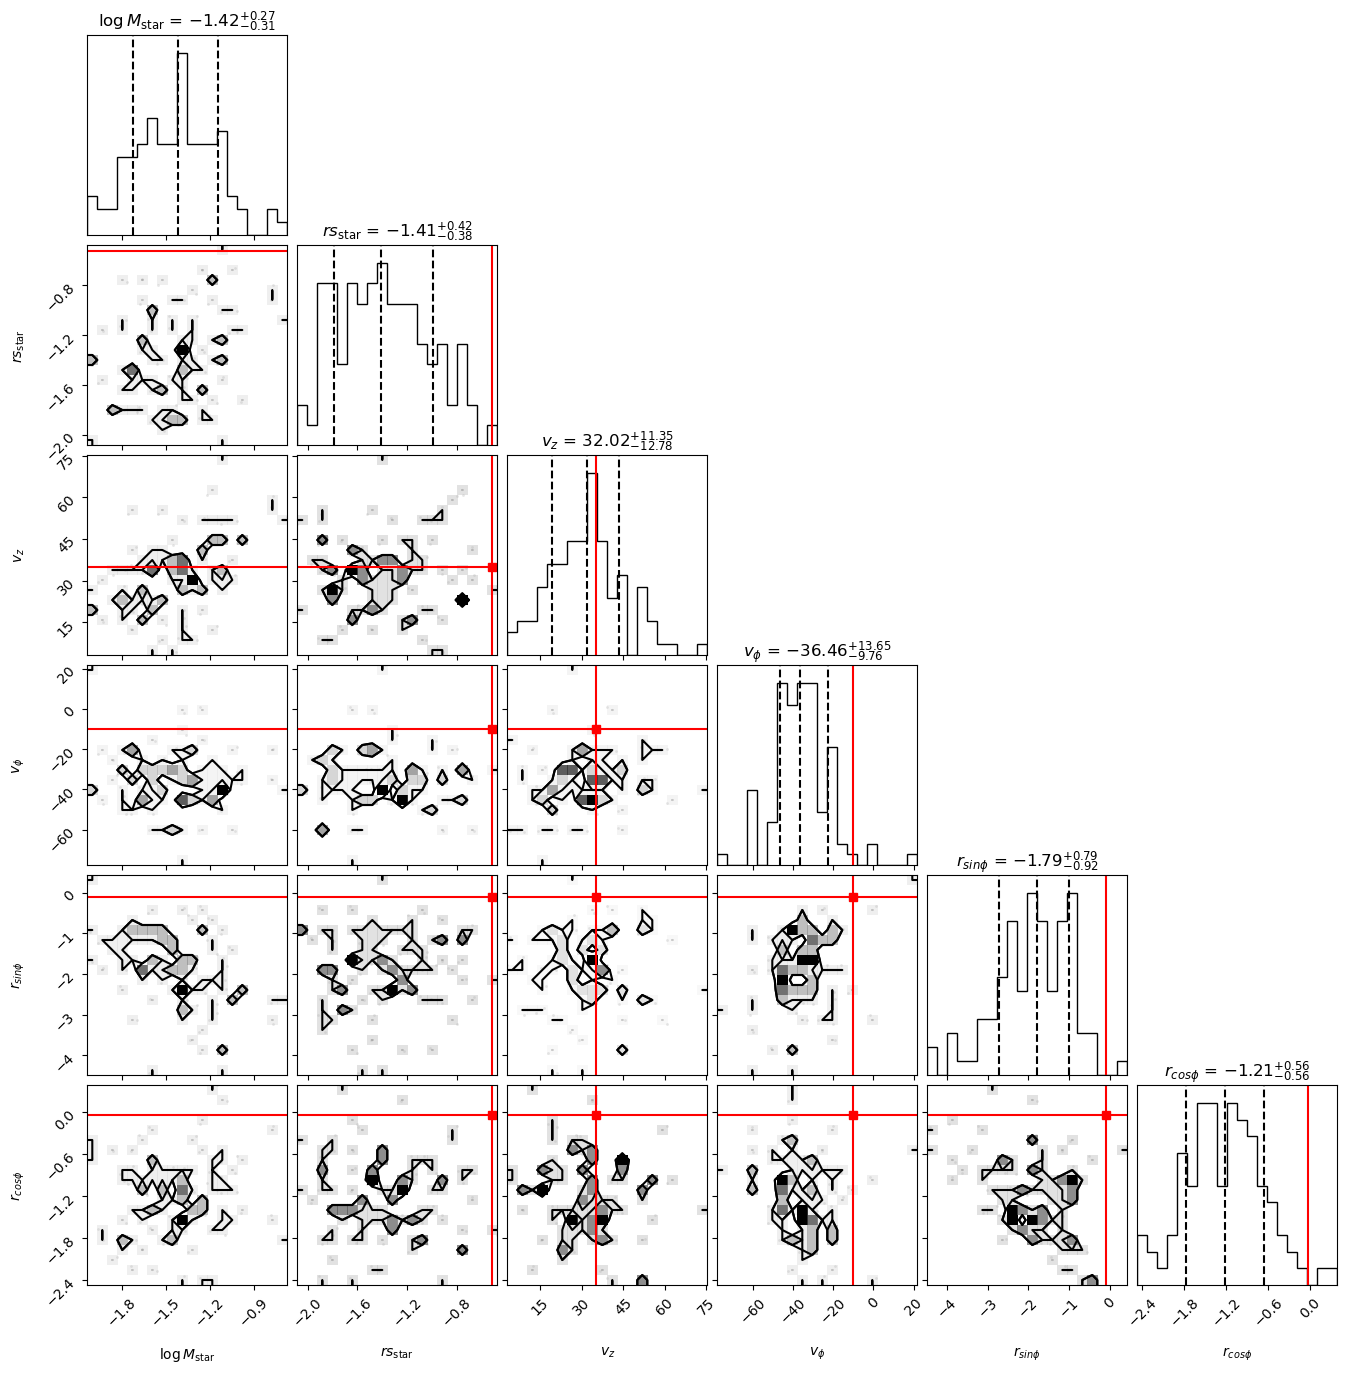

In [12]:
index = 0
fig = corner.corner(
    posteriors[index], 
    truths=truths[index],
    truth_color='r', 
    levels=[0.68, 0.95],
    quantiles=[0.16, 0.5, 0.84],
    labels=[r'$\log M_{\rm star}$', r'$rs_{\rm star}$', r'$v_z$', r'$v_{\phi}$', r'$r_{sin \phi}$', r'$r_{cos \phi}$'],
    show_titles=True,
)